In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

In [6]:
from sktime.datasets import load_from_tsfile_to_dataframe
from torch.utils.data import Dataset, DataLoader

# Load training and test data
X_train, y_train = load_from_tsfile_to_dataframe("/Users/kpalomak/data/IEEEPPG_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("/Users/kpalomak/data/IEEEPPG_TEST.ts")
y_train=np.array(y_train,'float')
y_test=np.array(y_test,'float')

mean=y_train.mean()
std=y_train.std()
y_train=(y_train-mean)/std
y_test=(y_test-mean)/std

In [7]:
def df_to_np(X):
    return np.stack([
        np.stack(row.values)  # stack channels
        for _, row in X.iterrows()  # iterate over samples
    ])


In [8]:
X_train_tmp_np=df_to_np(X_train)
X_test_tmp_np=df_to_np(X_test)

#y_train_np=df_to_np(y_train)

In [9]:
batch_size=1

def make_batches(X_np, batch_size=1):
    shape = X_np.shape  # (samples, features, time)
    nu_samples = shape[0]
    nu_features = shape[1]
    nu_time_steps = shape[2]

    assert nu_time_steps % batch_size == 0, "Time steps must be divisible by batch size"
    nu_split_batches = nu_time_steps // batch_size
    nu_batches = nu_samples * nu_split_batches

    # Reshape: (samples, features, split_batches, batch_size)
    X_np_new = X_np.reshape(nu_samples, nu_features, nu_split_batches, batch_size)
    X_np_new = X_np_new.transpose(0, 2, 1, 3)  # (samples, split_batches, features, batch_size)
    X_np_new = X_np_new.reshape(nu_batches, nu_features, batch_size)

    return X_np_new, nu_time_steps, nu_samples

X_train_tmp_np0, nu_time_steps, nu_samples=make_batches(X_np=X_train_tmp_np, batch_size=batch_size)
X_test_tmp_np0, nu_time_steps, nu_samples=make_batches(X_np=X_test_tmp_np, batch_size=batch_size)

print(X_train_tmp_np0.shape)
print(X_test_tmp_np0.shape)

(1768000, 5, 1)
(1328000, 5, 1)


In [10]:
from scipy.interpolate import interp1d
def matlab_interp(signal, fs_old, fs_new, kind='linear'):
    pad = 1
    padded_signal=signal
    padded_signal = np.pad(signal, (pad, pad), mode='edge')
    print(signal.shape)
    print(padded_signal.shape)
    x_old = np.arange(len(padded_signal)) / fs_old
    x_new = np.arange(0, x_old[-1], 1/fs_new)
    
    interpolator = interp1d(x_old, padded_signal, kind=kind, fill_value='extrapolate')
    out = interpolator(x_new)[int(fs_new/2):int(-fs_new/2)]
    return out

y_train_tmp_np=matlab_interp(y_train, 1, 1000)
y_test_tmp_np=matlab_interp(y_test, 1, 1000)


(1768,)
(1770,)
(1328,)
(1330,)


In [11]:
y_train_diff=np.convolve(y_train_tmp_np,[1,-2,1],mode='valid')<-0.0005
y_train_change_idx=np.append(np.where(y_train_diff==1)[0]+1000, len(y_train_tmp_np)-1)
y_test_diff=np.convolve(y_test_tmp_np,[1,-2,1],mode='valid')<-0.0005
y_test_change_idx=np.append(np.where(y_test_diff)[0]+1000, len(y_test_tmp_np)-1)

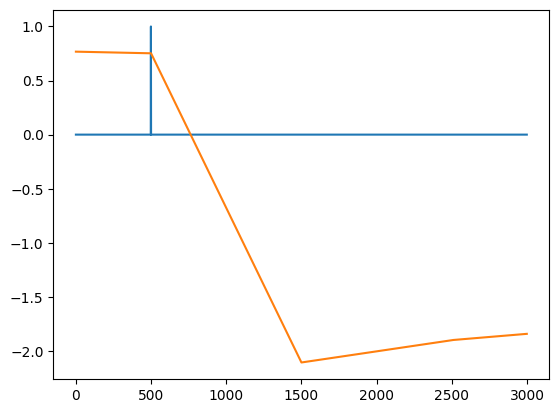

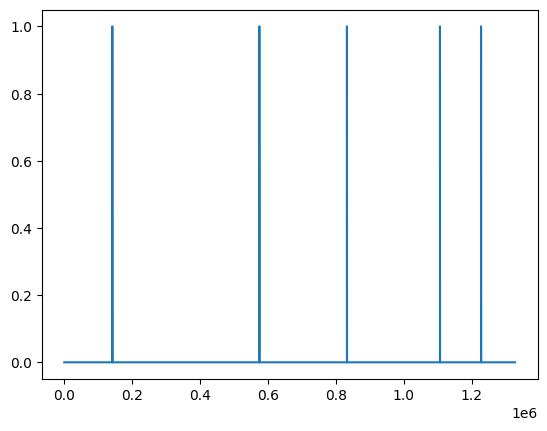

(11,)


In [12]:
# 5. Plot predictions
plt.figure(1)
plt.plot(y_train_diff[147000:150000])
plt.plot(y_train_tmp_np[147000:150000])

plt.figure(2)
plt.plot(y_test_diff)
plt.show()
print(y_train_change_idx.shape)

In [13]:
X_train_tmp_np1=X_train_tmp_np0.squeeze()#[:,0:2,:]
X_test_tmp_np1=X_test_tmp_np0.squeeze()#[:,0:2,:]

In [14]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, fs, lowcut=0.5, highcut=5, order=4):
    nyq = fs / 2
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [15]:
def preprocess_ppg(signal, clip_range=(-1000, 1000)):
    # 1. Clip outliers
    clipped = np.clip(signal, clip_range[0], clip_range[1])
    clipped=bandpass_filter(clipped, 125)
    # 2. Normalize: zero mean, unit variance
    mean = clipped.mean()
    std = clipped.std()
    if std == 0:
        std = 1  # avoid division by zero
    normalized = (clipped - mean) / std
    
    return normalized

In [16]:
def preprocess_mat(X):
    shape=X.shape
    plot=False
    nu_samples=shape[0]
    nu_features=shape[1]
    for fea in range(nu_features):
        preprocessed=preprocess_ppg(X[:,fea])
        X[:,fea]=preprocessed
        if plot==True:
            fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column
            axes[0].plot(preprocessed[:500])   
            axes[1].plot(X_train_tmp_np0[:500,0])
            plt.show()
            input('a')
    return X
    

In [17]:
print(X_train_tmp_np1.shape)
print(X_test_tmp_np1.shape)

X_train_tmp_np=preprocess_mat(X_train_tmp_np1)
X_test_tmp_np=preprocess_mat(X_test_tmp_np1)
print(X_train_tmp_np.shape)

(1768000, 5)
(1328000, 5)
(1768000, 5)


In [18]:
W=1000
step=100

def window_data(X,y,W,step,y_change_idx):
    idx_prev=-1
    nu_fea=X.shape[1]
    X_np=np.empty((0,W,nu_fea))
    y_np=np.empty((0))
    for idx in y_change_idx:
        print(idx_prev,idx)
        y_splitted=y[idx_prev+1:idx-1000]
        #print(X.shape)
        X_splitted=X[idx_prev+1:idx-1000,:]
        #print(X_train_splitted.shape)
        for idx_fea in range(nu_fea):
            mean=X_splitted[:,idx_fea].mean()
            std=X_splitted[:,idx_fea].std()
            X_splitted[:,idx_fea]=(X_splitted[:,idx_fea]-mean)/std

        y_windowed_one = sliding_window_view(y_splitted, window_shape=W)[::step][:,0]
        X_windowed_one = sliding_window_view(X_splitted, window_shape=(W, X_splitted.shape[1])).squeeze(1)[::step]
        
        X_np = np.concatenate([X_np, X_windowed_one], axis=0)
        y_np = np.concatenate([y_np, y_windowed_one], axis=0)
        #print(X_train_np.shape, y_train_np.shape, y_train_windowed_one.shape, X_train_windowed_one.shape)
        idx_prev=idx
        #plt.figure(1)
        #plt.plot(y_splitted)
        #plt.figure(2)
        #plt.plot(X_splitted)
        #plt.show()
        #input('a')
    X_np=X_np.transpose(0,2,1)
    return X_np, y_np

X_train_np, y_train_np=window_data(X_train_tmp_np, y_train_tmp_np, W, step, y_train_change_idx)
X_test_np, y_test_np=window_data(X_test_tmp_np, y_test_tmp_np, W, 500, y_test_change_idx)

-1 148499
148499 296499
296499 436499
436499 582499
582499 728499
728499 878499
878499 1021499
1021499 1181499
1181499 1479499
1479499 1622499
1622499 1767999
-1 142499
142499 575499
575499 833499
833499 1107499
1107499 1228499
1228499 1327999


In [19]:
print(X_train_np.shape)
print(y_train_np.shape)
#print(X_train_tmp_np2.shape)
if False:
    plt.plot(X_train_np[0,0,:])
    plt.plot(X_train_tmp_np[:1000,0]+1)

(17460, 5, 1000)
(17460,)


In [48]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor))


In [49]:
def torch_plotter(output_tensor):
    channel_to_plot = output_tensor[0, 0, :].detach().numpy()  # Detach from the graph to avoid tracking gradients
    
    # Plotting the first channel's output over time steps
    plt.plot(channel_to_plot)
    plt.title("Output of Conv1D - First Channel")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.show()

In [50]:
#torch_plotter(X_train_tensor)

In [51]:

# 2. Define CNN model
class PPGCNN(nn.Module):
    def __init__(self):
        super(PPGCNN, self).__init__()
        out_channels=30
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=out_channels, kernel_size=200, padding=5)
        self.relu = nn.ReLU() #Tanh() #ReLU()
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x):
        x = self.relu(self.conv1(x))      # [B, 16, 100]
        x = self.dropout(x)               # Apply dropout after activation
        x = self.pool(x)                  # [B, 16, 1]
        x = x.view(x.size(0), -1)         # [B, 16]
        x = self.fc(x)                    # [B, 1]
        return x



In [52]:
def eval_mod(X,y):
    model.eval()
    with torch.no_grad():
        preds = model(X).squeeze().numpy()*std+mean
        targets = y.squeeze().numpy()*std+mean
        mae = np.mean(np.abs(preds - targets))
        print(f"\nTest MAE: {mae:.2f} bpm")

In [53]:
# 3. Train the model
model = PPGCNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    first_round=True
    for xb, yb in train_loader:
        pred = model(xb)
        #print(pred.shape)
        #input('a')
        #first_round=False
        diff=torch.mean((pred[:-1,:]-pred[1:,:])**2)
        loss = criterion(pred, yb)+0.03*diff
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred_old=pred

    if np.mod(epoch,2)==0:
        # 4. Evaluate
        eval_mod(X_test_tensor, y_test_tensor)
        eval_mod(X_train_tensor, y_train_tensor)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss:.2f}")



Test MAE: 23.08 bpm

Test MAE: 16.61 bpm
Epoch 1/5, Loss: 213.25
Epoch 2/5, Loss: 189.79

Test MAE: 22.77 bpm

Test MAE: 14.56 bpm
Epoch 3/5, Loss: 145.56
Epoch 4/5, Loss: 132.83

Test MAE: 22.17 bpm

Test MAE: 13.95 bpm
Epoch 5/5, Loss: 127.36


In [44]:
# 4. Evaluate
if False:
    model.eval()
    with torch.no_grad():
        preds = model(X_train_tensor).squeeze().numpy()*std+mean
        targets = y_train_tensor.squeeze().numpy()*std+mean
        mae = np.mean(np.abs(preds - targets))
        print(f"\nTest MAE: {mae:.2f} bpm")

In [54]:
# 4. Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).squeeze().numpy()*std+mean
    targets = y_test_tensor.squeeze().numpy()*std+mean
    mae = np.mean(np.abs(preds - targets))
    print(f"\nTest MAE: {mae:.2f} bpm")


Test MAE: 22.17 bpm


0.0

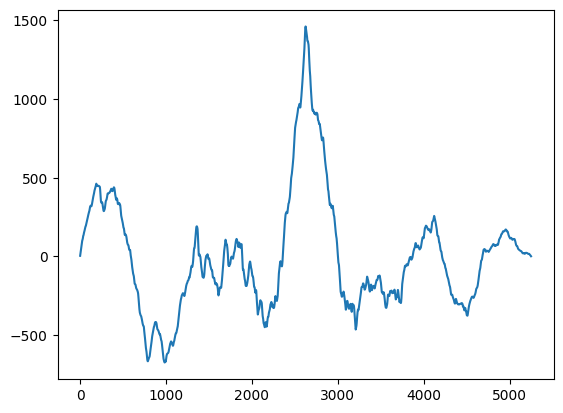

In [46]:
def calculate_delay(x, y, fs=1):
    """
    Returns the delay in seconds between two signals x and y.
    fs = sampling frequency (Hz)
    """
    corr = np.correlate(y, x, mode='full')  # Cross-correlation
    lags = np.arange(-len(x) + 1, len(y))
    delay_samples = lags[np.argmax(corr)]
    delay_seconds = delay_samples / fs
    plt.plot(corr)
    return delay_seconds


def limited_delay_estimation(x, y, fs=1, max_lag_sec=500):
    x = (x - np.mean(x)) / (np.std(x) + 1e-8)
    y = (y - np.mean(y)) / (np.std(y) + 1e-8)
    corr = np.correlate(y, x, mode='full')
    lags = np.arange(-len(x) + 1, len(y))
    
    max_lag_samples = int(max_lag_sec * fs)
    mid = len(corr) // 2
    search_range = slice(mid - max_lag_samples, mid + max_lag_samples + 1)

    corr_window = corr[search_range]
    lags_window = lags[search_range]
    plt.plot(corr)

    delay_samples = lags_window[np.argmax(corr_window)]
    return delay_samples / fs


limited_delay_estimation(preds[:-6],targets[6:])

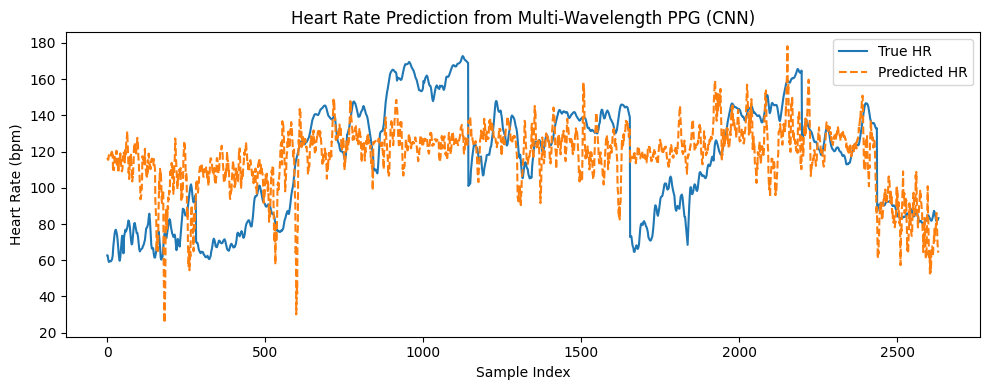

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [55]:
# 5. Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(targets, label="True HR")
plt.plot(preds, label="Predicted HR", linestyle='--')
plt.title("Heart Rate Prediction from Multi-Wavelength PPG (CNN)")
plt.xlabel("Sample Index")
plt.ylabel("Heart Rate (bpm)")
plt.legend()
plt.tight_layout()
plt.show()
plt.clf()  # Clear the figure to avoid any interference with the next plot
plt.figure(figsize=(10, 4))

# 6. Plot PPG data
for i in range(100):
    if np.max(np.abs(X_train_np[i,0,:]))>200:
        plt.plot(X_train_np[i,0,:], label="PPG Signal")  # Assuming X is your input PPG data
        plt.title("PPG Signal for Sample 0")
        plt.xlabel("Sample Index")
        plt.ylabel("PPG Amplitude")
        plt.legend()
        plt.tight_layout()
        plt.show()  # Display the second plot
        print(i)
        input('a')

In [165]:
X_train.shape

(1768, 5)